In [1]:
import torch
import torch.optim as optim
import numpy as np
import scanpy as sc
import scvelo as scv
import sys, os
current_dir = os.getcwd()
sys.path.append(os.path.abspath(os.path.join(current_dir, '..')))
from model import NETWORK  # Ensure that model.py is saved in the same directory
from dataloaders import * # Ensure that dataloaders.py is saved in the same directory
from utils import *
from sklearn.manifold import Isomap
from sklearn.neighbors import kneighbors_graph
from scipy.sparse.csgraph import dijkstra
import gc
import pandas as pd
import seaborn as sns

In [2]:
# Setup configuration
latent_dim = 64  # Latent dimension size, can be adjusted
hidden_dim = 512  # Hidden dimension size for the encoder and decoder
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Use GPU if available

n_components = 100
n_knn_search = 10
dataset_name = "gastrulation_erythroid"
cell_type_key = "clusters"
model_name = "imVelo"

num_genes = 2000
nhead = 1 #original: 1
embedding_dim = 128*nhead# original: 128
num_encoder_layers = 1 #original: 1
num_bins = 50
batch_size = 24  # Batch size for training
epochs = 10  # Number of epochs for training
learning_rate = 1e-4  # Learning rate for the optimizer
lambda1 = 1  # Weight for heuristic loss
lambda2 = 1 # Weight for discrepancy loss
K = 11  # Number of neighbors for heuristic loss

# Load data
adata = sc.read_h5ad("pancreas_minmax.h5ad")

adata.obs[cell_type_key] = [str(cat) for cat in list(adata.obs[cell_type_key])]
adata.obs[cell_type_key] = pd.Series(adata.obs[cell_type_key], dtype="category")
unique_categories = adata.obs[cell_type_key].cat.categories
rgb_colors = sns.color_palette("tab20", len(unique_categories))
hex_colors = ['#%02x%02x%02x' % (int(r*255), int(g*255), int(b*255)) for r, g, b in rgb_colors]
adata.uns[f"{cell_type_key}_colors"] = hex_colors
print(dataset_name)
adata.layers['counts_unspliced'] = adata.layers["unspliced"].copy()
adata.layers['counts_spliced'] = adata.layers["spliced"].copy()

# Initialize model, optimizer, and loss function
model = NETWORK(input_dim=adata.shape[1]*2, latent_dim=latent_dim, 
                hidden_dim=hidden_dim, emb_dim = embedding_dim,
                nhead=nhead, num_encoder_layers=num_encoder_layers,
                num_genes=num_genes, num_bins=num_bins).to(device)
                
model.load_state_dict(torch.load('final_model.pth'))

# Ensure to call model.eval() if you're loading the model for inference to set the dropout and batch normalization layers to evaluation mode
model.eval()


gastrulation_erythroid


NETWORK(
  (embeddings): Embedding(4000, 128)
  (encoder_layer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
    )
    (linear1): Linear(in_features=128, out_features=512, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=512, out_features=128, bias=True)
    (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, inplace=

In [11]:
_, _, full_data_loader = setup_dataloaders_binning(adata, 
                                                    batch_size=batch_size, 
                                                    num_genes=num_genes, 
                                                    num_bins=num_bins)

# Initialize empty layers in adata for storing results
adata.layers["velocity_u"] = np.zeros_like(adata.layers["Mu"], dtype=np.float32)
adata.layers["velocity"] = np.zeros_like(adata.layers["Ms"], dtype=np.float32)
adata.obsm["pred"] = np.zeros((adata.shape[0], adata.shape[1] * 2), dtype=np.float32)
adata.obsm["cell_embeddings"] = np.zeros((adata.shape[0], adata.shape[1] * 2), dtype=np.float32)
adata.layers["pp"] = np.zeros_like(adata.layers["Mu"])  # Same shape as Mu
adata.layers["nn"] = np.zeros_like(adata.layers["Mu"])  # Same shape as Mu
adata.layers["pn"] = np.zeros_like(adata.layers["Mu"])  # Same shape as Mu
adata.layers["np"] = np.zeros_like(adata.layers["Mu"])  # Same shape as Mu
model.eval()
with torch.no_grad():
    for batch_idx, (tokens, data, batch_indices) in enumerate(full_data_loader):
        print(f"Batch {batch_idx+1}/{len(full_data_loader)}")
        tokens = tokens.to(device)
        data = data.to(device)
        out_dic = model(tokens, data)

        # Store results and convert to numpy inside the loop to reduce peak memory usage
        adata.layers["velocity_u"][batch_indices] = out_dic["v_u"].detach().cpu().numpy()
        adata.layers["velocity"][batch_indices] = out_dic["v_s"].detach().cpu().numpy()
        adata.obsm["pred"][batch_indices] = out_dic["pred"].detach().cpu().numpy()
        adata.obsm["cell_embeddings"][batch_indices] = out_dic["cell_embeddings"].detach().cpu().numpy()
        adata.layers["pp"][batch_indices] = out_dic["pp"].cpu().numpy()
        adata.layers["nn"][batch_indices] = out_dic["nn"].cpu().numpy()
        adata.layers["pn"][batch_indices] = out_dic["pn"].cpu().numpy()
        adata.layers["np"][batch_indices] = out_dic["np"].cpu().numpy()

        # Explicit memory cleanup
        del tokens, data, out_dic
        gc.collect()
        torch.cuda.empty_cache()  # If using CUDA

Batch 1/154
Batch 2/154
Batch 3/154
Batch 4/154
Batch 5/154
Batch 6/154
Batch 7/154
Batch 8/154
Batch 9/154
Batch 10/154
Batch 11/154
Batch 12/154
Batch 13/154
Batch 14/154
Batch 15/154
Batch 16/154
Batch 17/154
Batch 18/154
Batch 19/154
Batch 20/154
Batch 21/154
Batch 22/154
Batch 23/154
Batch 24/154
Batch 25/154
Batch 26/154
Batch 27/154
Batch 28/154
Batch 29/154
Batch 30/154
Batch 31/154
Batch 32/154
Batch 33/154
Batch 34/154
Batch 35/154
Batch 36/154
Batch 37/154
Batch 38/154
Batch 39/154
Batch 40/154
Batch 41/154
Batch 42/154
Batch 43/154
Batch 44/154
Batch 45/154
Batch 46/154
Batch 47/154
Batch 48/154
Batch 49/154
Batch 50/154
Batch 51/154
Batch 52/154
Batch 53/154
Batch 54/154
Batch 55/154
Batch 56/154
Batch 57/154
Batch 58/154
Batch 59/154
Batch 60/154
Batch 61/154
Batch 62/154
Batch 63/154
Batch 64/154
Batch 65/154
Batch 66/154
Batch 67/154
Batch 68/154
Batch 69/154
Batch 70/154
Batch 71/154
Batch 72/154
Batch 73/154
Batch 74/154
Batch 75/154
Batch 76/154
Batch 77/154
Batch 78

In [12]:
np.isnan(adata.layers["velocity_u"]).sum()

0

In [13]:
np.isnan(adata.layers["velocity"]).sum()

0

In [14]:
adata.obsm["MuMs"] = np.concatenate([adata.layers["Mu"], adata.layers["Ms"]], axis=1)
adata.obsm["velocity"] = np.concatenate([adata.layers["velocity_u"], adata.layers["velocity"]], axis=1)

In [15]:
#adata.layers["velocity_u"] *= -1
#adata.layers["velocity"] *= -1

computing velocity graph (using 1/24 cores)
or disable the progress bar using `show_progress_bar=False`.
    finished (0:00:05) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence' (adata.obs)
--> added 'velocity_confidence_transition' (adata.obs)
computing terminal states
    identified 6 regions of root cells and 2 regions of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)


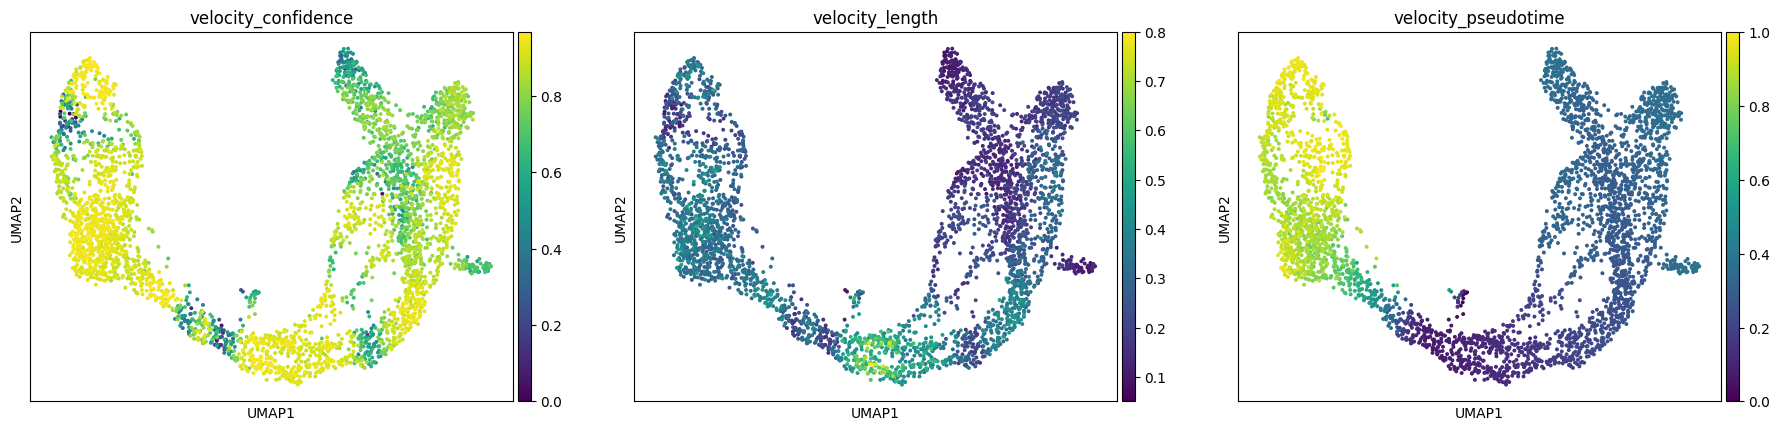

computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


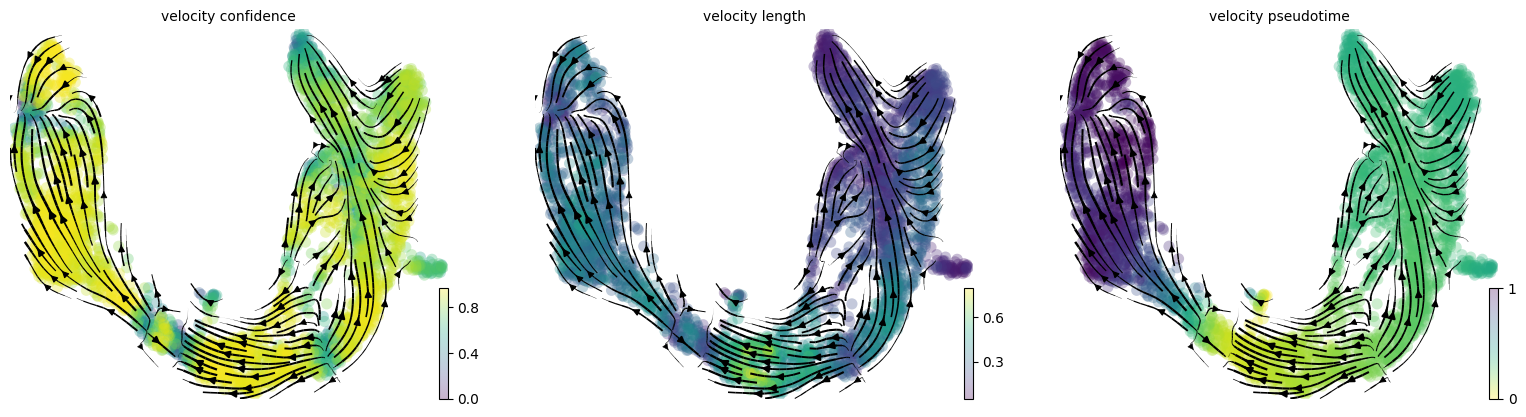

In [16]:
sc.pp.neighbors(adata)
scv.tl.velocity_graph(adata)
scv.tl.velocity_confidence(adata)
scv.tl.velocity_pseudotime(adata)
keys = ["velocity_confidence", "velocity_length", "velocity_pseudotime"]
sc.pl.umap(adata, color=keys)
scv.pl.velocity_embedding_stream(adata, color=keys, basis="umap")

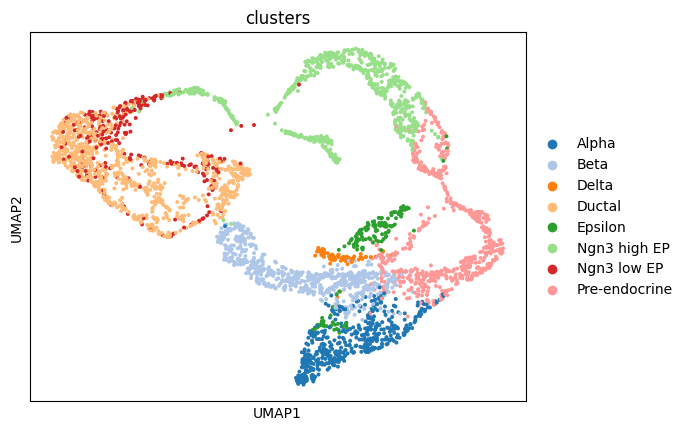

In [18]:
sc.pp.neighbors(adata,use_rep="velocity")
sc.tl.umap(adata)
keys = [cell_type_key]
sc.pl.umap(adata, color=keys)

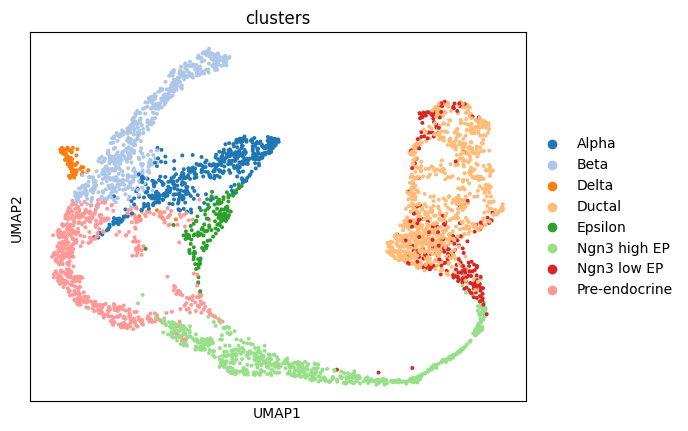

In [20]:
sc.pp.neighbors(adata, use_rep="cell_embeddings")
sc.tl.umap(adata)
sc.pl.umap(adata, color=[cell_type_key])

In [21]:
scv.tl.rank_velocity_genes(adata, groupby=cell_type_key)
pd.DataFrame(adata.uns["rank_velocity_genes"]["names"])

ranking velocity genes
    finished (0:00:01) --> added 
    'rank_velocity_genes', sorted scores by group ids (adata.uns) 
    'spearmans_score', spearmans correlation scores (adata.var)


,Alpha,Beta,Delta,Ductal,Epsilon,Ngn3 high EP,Ngn3 low EP,Pre-endocrine
0,Foxo1,Iapp,Dcaf6,Tex30,Kdm5a,Clu,Npl,H2-Ke6
1,Rab22a,Jarid2,Mbd6,Lig1,Syn1,Rps4x,Spon1,Abat
2,Exoc7,Ppp1r1a,Ppp3cc,Pola1,Gabarapl1,Eps8l2,Celf2,Slc25a53
3,Filip1,P2ry1,Mrpl1,Dut,Soga1,Ccnd3,Mif,2210013O21Rik
4,Mlxipl,Vps8,Soga1,Cenph,Pcsk1n,Plk2,Tkt,Ppm1b
...,...,...,...,...,...,...,...,...
95,Selk,Dock8,Slc43a2,Mmd2,Cplx2,Plekha1,Msmo1,Cfap77
96,Ptprz1,Pdia3,Trappc2l,Sh3kbp1,Ctnnd2,Bmp7,Dtymk,Gria3
97,Lrrc42,Eps8,Vps37b,Snx18,Plcb1,Qsox1,Rap1gds1,Gpd2
98,Pip5k1b,Clstn2,Asic2,Diaph2,Ccdc112,Pbld2,Etv1,Pyy


In [22]:
gene_names = ["Actb", "Rbfox3", "Gnas", "Gcg", "Ins1"]

In [23]:
"""for stage in adata.obs["stage"].unique():
    adata_tmp = adata[adata.obs["stage"] == stage].copy()
    sc.pp.neighbors(adata_tmp)
    sc.tl.umap(adata_tmp)
    scv.pl.velocity_embedding_stream(adata_tmp, color=[cell_type_key], basis="umap")
    for gene_name in gene_names:
        plot_phase_plane(adata_tmp, gene_name, dataset_name, 11, 
                    u_scale=0.1, s_scale=0.1, cell_type_key=cell_type_key,
                    save_path="plots/plot1.png")"""

'for stage in adata.obs["stage"].unique():\n    adata_tmp = adata[adata.obs["stage"] == stage].copy()\n    sc.pp.neighbors(adata_tmp)\n    sc.tl.umap(adata_tmp)\n    scv.pl.velocity_embedding_stream(adata_tmp, color=[cell_type_key], basis="umap")\n    for gene_name in gene_names:\n        plot_phase_plane(adata_tmp, gene_name, dataset_name, 11, \n                    u_scale=0.1, s_scale=0.1, cell_type_key=cell_type_key,\n                    save_path="plots/plot1.png")'

Plot saved to plots/plot1.png


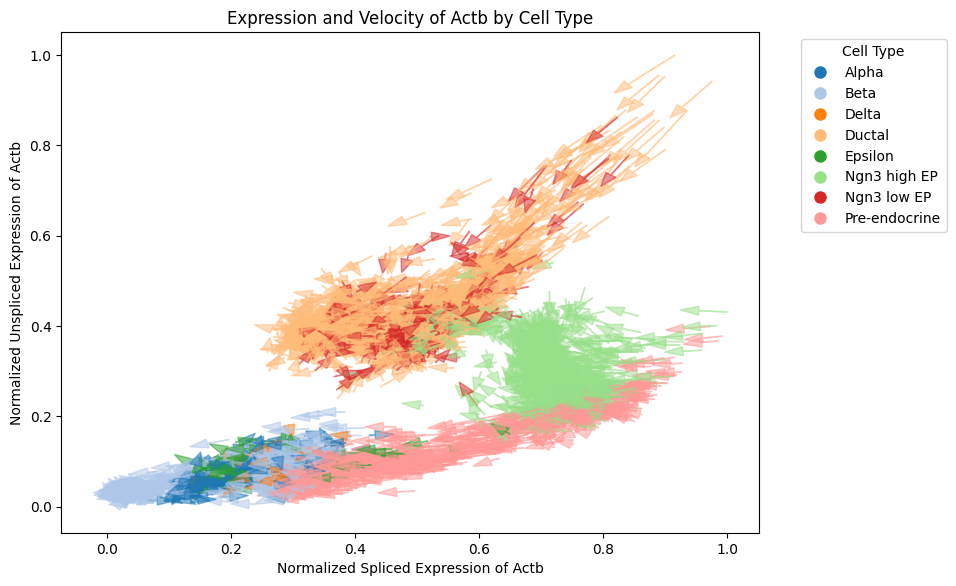

Plot saved to plots/plot1.png


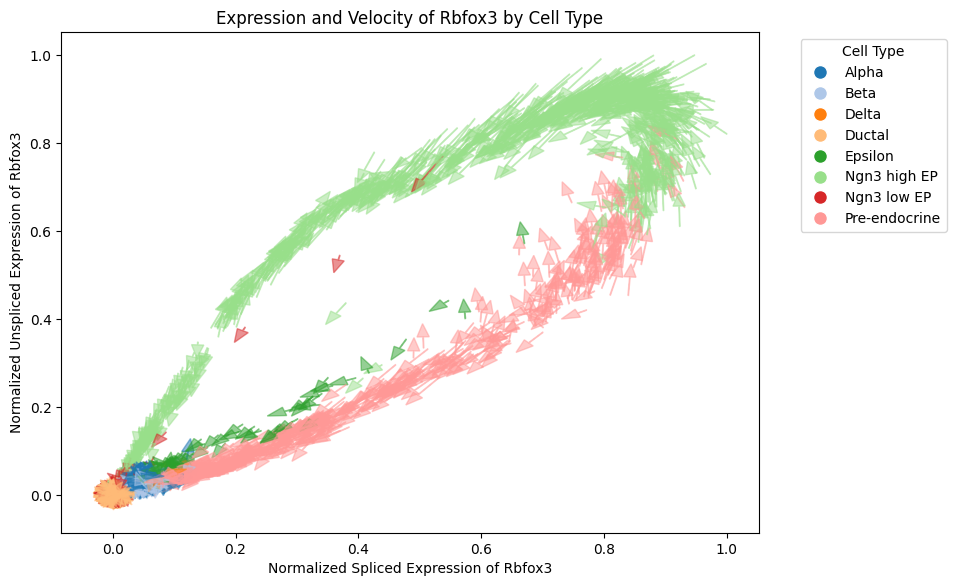

Plot saved to plots/plot1.png


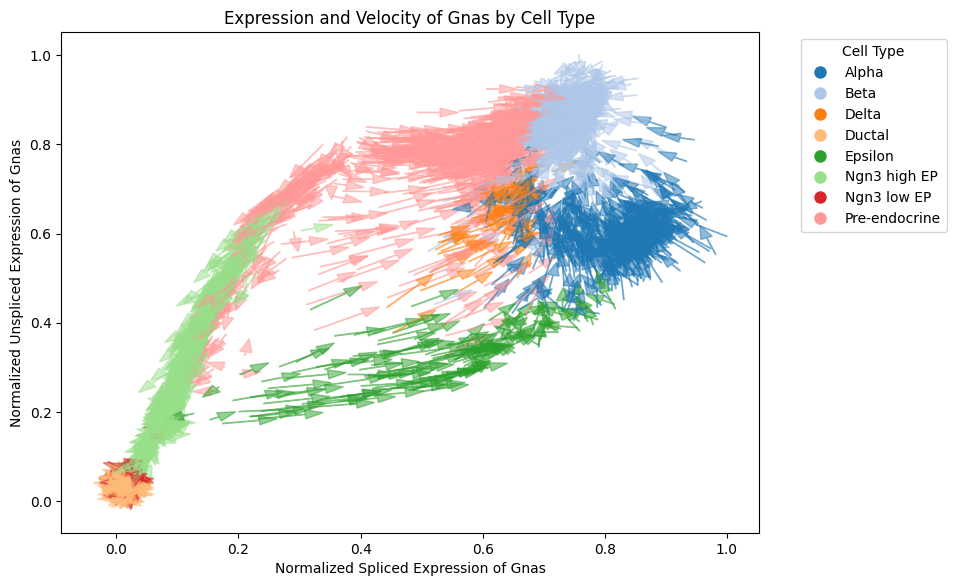

Plot saved to plots/plot1.png


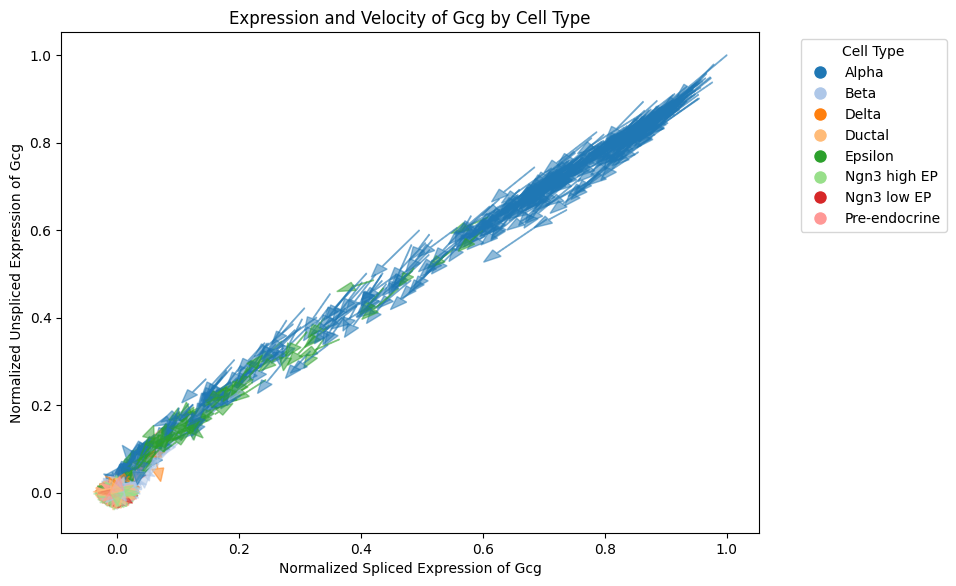

Plot saved to plots/plot1.png


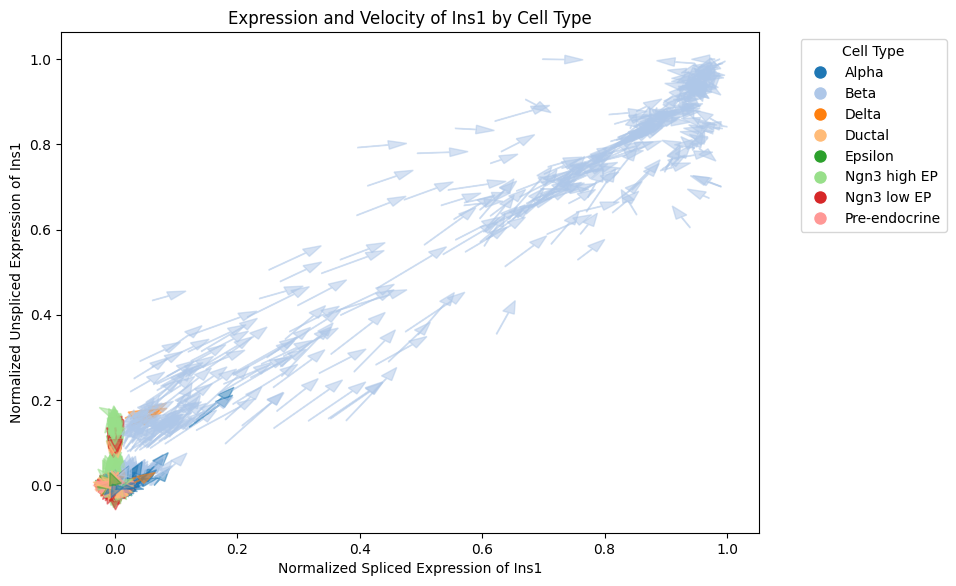

In [24]:
for gene_name in gene_names:
    plot_phase_plane(adata, gene_name, dataset_name, 11, 
                    u_scale=0.1, s_scale=0.1, cell_type_key=cell_type_key,
                    save_path="plots/plot1.png")    